<a href="https://colab.research.google.com/github/davidbro-in/natural-language-processing/blob/main/2_rules_based_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 6.4 MB 4.6 MB/s 
     |████████████████████████████████| 623 kB 44.8 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 456 kB 69.5 MB/s 
     |████████████████████████████████| 10.1 MB 24.4 MB/s 
     |████████████████████████████████| 342 kB 6.0 MB/s 


In [2]:
import json
import string
import random 
import numpy as np


#vamos con redes neuronales. Podria ser con Random Forest tmb, total es un clasificador
import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import stanza
import spacy_stanza

# Descargar el diccionario en español y armar el pipeline de NLP con spacy. Siempre debo descargar cuando uso el Colab, para que no se guarde en mi drive.
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2021-10-20 03:56:45 INFO: Downloading default packages for language: es (Spanish)...


2021-10-20 03:58:49 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-10-20 03:58:49 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-10-20 03:58:49 INFO: Use device: cpu
2021-10-20 03:58:49 INFO: Loading: tokenize
2021-10-20 03:58:49 INFO: Loading: mwt
2021-10-20 03:58:49 INFO: Loading: pos
2021-10-20 03:58:49 INFO: Loading: lemma
2021-10-20 03:58:49 INFO: Loading: depparse
2021-10-20 03:58:50 INFO: Loading: ner
2021-10-20 03:58:51 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar tildes y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [4]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') #saco caracteres que estan en la tabla alta de ascii, que son los que tienen tilde.
    # quitar caracteres especiales: parecido a los signos de puntuacion. "quiero solo de la a a la Z, .."
    #pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' #en vez de usar a-zA-z0-9, se puede usar \w 
    #text = re.sub(pattern, '', text)
    #pattern = r'[^a-zA-z.,!?/:;\"\'\s]' #esta esta linea como extra, despues la comento si quiero dejar numeros
    pattern = r'[^a-zA-z\s]'
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    #text = ''.join([char for char in text if char not in string.punctuation])   #va sacando character por character que no este en string.punctuation
    return text



In [5]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [6]:
# Ejemplo de como fuciona
text = "personas $Ideas! estás cosas 99 y los peces y los muerciélagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto (spicy lo hace, pero lo hago por las dudas)
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("")
print("Lematización de cada token:")
for token in tokes:
    print(token.lemma_)


tokens: personas ideas estas cosas  y los peces y los muercielagos

Lematización de cada token:
persona
idea
este
cosa
 
y
el
pez
y
el
muercielago


### 3 - Diccionario de entrada

In [7]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
#las preguntas se deben tratar de cerrar en forma redonda, porque son preguntas y respuestas puntuales, no se tiene en cuenta lo previo
#LO VAMOS A HACER APLICADO A UN CENTRO DE CLASES PARTICULARES: RUCON
dataset = {"intents": [
             {"tag": "bienvenida",
              #les estoy dando mucho peso al Hola. Hay que tener cuidado
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "Buenos dias", "wenas", "Buenas", "como va?", "todo bien?"],  #no necesariamente tiene que ser asi, puede tener muchas varaciones (tildes, espacios, etc). Para esto sirve Deep L
              "responses": ["Hola! ¿Con qué consulta te puedo ayudar?", "Hola! ¿En qué puedo ayudarte?",], #en forma aleatoria responde esto
             },
             {"tag": "nombre",
              "patterns": ["Cúal es tu nombre?", "Quién sos?", "Cómo te llamas?", "Con quien hablo?"],
              "responses": ["Soy RuconBot, parte del equipo de Rucon!"]
             },
             {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al siguiente <numero>", "Contactos al whatsapp <numero>"]
             },
             {"tag": "ubicacion",
              "patterns": ["Donde están?", "En que zona trabajan", "Tienen oficina?"],
              "responses": ["Hoy en día damos todas nuestras clases de manera online! Te dejo nuestro link: <link_sitio_web>"]
             },
             {"tag": "precios_cursos",
              "patterns": ["cuanto cuesta cada curso?", "Me podrás pasar los precios?", "Cuánto valen los cursos?", "Cuánto sale el curso?", "Que valor tienen los cursos?"],
              "responses": ["En el siguiente link podrás encontrar los precios de todos nuestros cursos:<link_precios_cursos>"]
             },
             {"tag": "formas_pagos",
              "patterns": ["qué medios de pagos tienen?", "aceptan tarjeta de crédito?", "aceptan tarjeta?", "se puede pagar en cuotas?", "usan mercado pago?","que formas de pagos tienen?"],
              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes: <link_pagos>"]
             },
             {"tag": "cursos_cuales",
              "patterns": ["Qué cursos tienen?", "Que cursos hay?", "Para que materias tienen cursos?"],
              "responses": ["Aca te dejo un link con los cursos disponibles! <link_cursos_disponibles>"]
             },
             {"tag": "cursos_informacion",
              "patterns": ["Que incluyen los cursos?", "que se ve en los cursos?", "Que tienen los cursos?"],
              "responses": ["Te dejo un link con lo que incluye cada curso! <link_cursos_informacion>"]
             },
             {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias", "Te agradezco"],
              "responses": ["Por nada! Quedamos en contacto :)", "Igualmente! Estamos en contacto"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!", "Saludos"],
              "responses": ["Hasta luego!", "Saludos!", "Hablamos!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [8]:
# Datos que necesitaremos, las palabras o vocabUlario
words = []   #palabras del dataste
classes = [] #array
doc_X = []   #no en frases, sino en tokens
doc_y = []   #idem

# Por cada intención (intents) debemos tomar los patrones que la caracterízan  #Intentos son divisiones del dataset
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:  #la comunicacion del alumno
        # trasformar el patron a tokens
        tokens = preprocess_clean_text(pattern.lower())  
        tokens = nlp(tokens)  #nlp lo lematiza: peces a pez. 
        # lematizar los tokens. Hacemos la lista  #separo en terminos separados
        for token in tokens:            
            words.append(token.lemma_)  #devuelve la raíz de la palabra
        
        #una fila de x con una de y. Ya no tengo tags
        doc_X.append(pattern)  
        doc_y.append(intent["tag"])  #la salida ees el tag, para poder entrenar el modelo
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))  #en words estan todas las palabras del dataset lemmatizadas
classes = sorted(set(classes))  #no está de más esto? 

In [ ]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['aceptar', 'agradecer', 'bien', 'buen', 'cada', 'chau', 'como', 'con', 'contacto', 'costar', 'credito', 'cual', 'cuanto', 'cuota', 'curso', 'de', 'dia', 'donde', 'el', 'en', 'estar', 'este', 'forma', 'gracias', 'haber', 'hablar', 'hasta', 'holar', 'incluir', 'ir', 'llama', 'luego', 'materia', 'medio', 'mercado', 'mucho', 'nombre', 'numero', 'oficina', 'pagar', 'pago', 'para', 'pasar', 'poder', 'precio', 'que', 'quien', 'salir', 'saludo', 'ser', 'tal', 'tarjeta', 'telefono', 'tener', 'todo', 'trabajar', 'tu', 'tú', 'usar', 'valer', 'valor', 'ver', 'wenas', 'whatsapp', 'yo', 'zona', 'él']
classes: ['agradecimientos', 'bienvenida', 'contacto', 'cursos_cuales', 'cursos_informacion', 'despedida', 'formas_pagos', 'nombre', 'precios_cursos', 'ubicacion']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', 'Buenos dias', 'wenas', 'Buenas', 'como va?', 'todo bien?', 'Cúal es tu nombre?', 'Quién sos?', 'Cómo te llamas?', 'Con quien hablo?', 'contacto', 'número de contacto', 'número de teléfono'

In [9]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 67


In [10]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0). No tengo funcion de onehot encoding porque son puros arreglos
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 5 - Entrenamiento del modelo

In [11]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]

# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8704      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 17,610
Trainable params: 17,610
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 8ms/step - loss: 2.3065 - accuracy: 0.1395
Epoch 2/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2902 - accuracy: 0.1628
Epoch 3/200
2/2 [==============================] - 0s 7ms/step - loss: 2.2856 - accuracy: 0.1163
Epoch 4/200
2/2 [==============================] - 0s 7ms/step - loss: 2.3086 - accuracy: 0.1395
Epoch 5/200
2/2 [==============================] - 0s 7ms/step - loss: 2.2884 - accuracy: 0.1163
Epoch 6/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2431 - accuracy: 0.2326
Epoch 7/200
2/2 [==============================] - 0s 7ms/step - loss: 2.2252 - accuracy: 0.1628
Epoch 8/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2222 - accuracy: 0.1163
Epoch 9/200
2/2 [==============================] - 0s 7ms/step - loss: 2.2205 - accuracy: 0.3023
Epoch 10/200
2/2 [==============================] - 0s 7ms/step - loss: 2.2069 - accuracy: 0.3023
Epoch 11/200
2/2 [===========

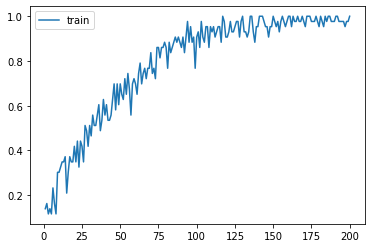

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [14]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo

import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [15]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [16]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

Hola
BOT: Hola! ¿En qué puedo ayudarte?
Quiero información
Perdón, no comprendo la pregunta.
Qué cursos tienen?
BOT: Aca te dejo un link con los cursos disponibles! <link_cursos_disponibles>
Y cuánto valen?
BOT: En el siguiente link podrás encontrar los precios de todos nuestros cursos:<link_precios_cursos>
ok, muchas gracias!
BOT: Igualmente! Estamos en contacto


KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words